In [23]:
import os
import pandas as pd
import geopandas as gpd
import fiona
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import rasterio  
from rasterio.plot import show
from matplotlib.lines import Line2D
import xarray as xr
from pyproj import Transformer
from scipy.interpolate import griddata
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import harmonica as hm
import verde as vd
#from numpy.linalg import lstsq   # DO NOT USE THIS TIME TAKING
from shapely.geometry import Point, Polygon
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objects as go
import pyvista as pv
from sklearn.decomposition import DictionaryLearning
from itertools import product
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.sparse import csr_matrix, vstack, eye, hstack
from scipy.sparse.linalg import lsmr
from joblib import Parallel, delayed
from tqdm import tqdm
import plotly.express as px
from scipy.spatial import cKDTree
from simpeg.potential_fields import gravity
from simpeg.utils import plot2Ddata, model_builder, download
from simpeg import (maps, data, data_misfit, inverse_problem, regularization, optimization, directives, inversion,)
# discretize functionality
import matplotlib as mpl
from discretize import TensorMesh, TreeMesh
from discretize.utils import active_from_xyz

In [2]:
mpl.rcParams.update({"font.size": 14})

In [3]:
density_X_dir = r"C:\Data\ONGC\AIKosh\ground_gravity_data_of_karnataka_and_andhra_pradesh_v1\Ground_gravity_asci_grid_geotiff\Physical_properties_rock_samples_Copy.csv"
ngpm_grav_dir = r"C:\Data\ONGC\AIKosh\ground_gravity_data_of_karnataka_and_andhra_pradesh_v1\Ground_gravity_asci_grid_geotiff\ASCII\combined_NGPM_gravity - Copy.csv"
bouguer_anomaly_dir = r"C:\Data\ONGC\AIKosh\ground_gravity_data_of_karnataka_and_andhra_pradesh_v1\Ground_gravity_asci_grid_geotiff\GEOTIFF\NGPM_BA.tiff"
gdb_dir = r"C:\Data\ONGC\AIKosh\aerogeophysical_spectrometric_data_of_karnataka_and_andhra_pradesh_v1\SPECTROMETRIC\DATABASE\GDB\spec.gdb"
tail_tmi_ge = r"C:\Data\ONGC\AIKosh\aerogeophysical_magnetic_data_of_karnataka_and_andhra_pradesh_v1\MAGNETIC\GRIDS\GEOTIFF\TAIL_TMI_GE.tiff"
geo_map_dir = r"C:\Data\ONGC\AIKosh\Geological_Map.tif"
output_dir = r"C:\Data\ONGC\AIKosh\OUTPUT\GM Data"
boundary_loc = r"C:\Data\ONGC\AIKosh\OUTPUT\GM Data\Boundary1_For_Magnetic_Inversion.bln"
boundary_loc2 = r"C:\Data\ONGC\AIKosh\OUTPUT\GM Data\Boundary5_south_For_Magnetic_Inversion.bln"

In [4]:
df_bouguer = pd.read_csv(ngpm_grav_dir)
df_bouguer.head()

,X,Y,bouguer_an,elevation,observed_g,theoretical_g,gravity_anomaly,toposheet
0,76.8616,14.2522,-72,548,978164,978345,-181,57B/15
1,76.9966,14.2552,-68,576,978164,978345,-181,57B/15
2,76.9861,14.2556,-67,573,978165,978345,-180,57B/15
3,76.8458,14.2535,-72,541,978165,978345,-180,57B/15
4,76.9423,14.2554,-68,558,978167,978345,-178,57B/15


In [5]:
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32643", always_xy=True)
utm_x, utm_y = transformer.transform(df_bouguer["X"].values, df_bouguer["Y"].values)

In [6]:
#residuals = df_bouguer["residual_bouguer"].values
elevation = df_bouguer["elevation"].values

### SimPEG Method

##### (1) Setting Up File

In [9]:
df_bouguer['UTM_X'] = utm_x
df_bouguer['UTM_Y'] = utm_y
df_coords = df_bouguer.copy()

In [10]:
df_coords

,X,Y,bouguer_an,elevation,observed_g,theoretical_g,gravity_anomaly,toposheet,UTM_X,UTM_Y
0,76.8616,14.2522,-72,548,978164,978345,-181,57B/15,700845.713235,1.576422e+06
1,76.9966,14.2552,-68,576,978164,978345,-181,57B/15,715412.912937,1.576875e+06
2,76.9861,14.2556,-67,573,978165,978345,-180,57B/15,714279.294164,1.576909e+06
3,76.8458,14.2535,-72,541,978165,978345,-180,57B/15,699139.405519,1.576552e+06
4,76.9423,14.2554,-68,558,978167,978345,-178,57B/15,709552.261319,1.576847e+06
...,...,...,...,...,...,...,...,...,...,...
22811,76.7644,15.0312,-86,585,978178,978380,-202,57A/16,689684.770344,1.662534e+06
22812,76.7585,15.0224,-87,594,978175,978379,-204,57A/16,689058.067629,1.661556e+06
22813,76.7560,15.0133,-87,599,978173,978379,-206,57A/16,688797.209246,1.660547e+06
22814,76.8422,15.0198,-87,513,978191,978379,-188,57A/16,698061.743988,1.661341e+06


In [16]:
with open(boundary_loc2, 'r') as f:
    lines = f.readlines()

boundary_coords = []
for line in lines:
    parts = line.replace(',', ' ').split()
    nums = [float(p) for p in parts]
    boundary_coords.append(nums)

boundary_coords = np.array(boundary_coords)

In [21]:
boundary_polygon = Polygon(boundary_coords)

In [13]:
topo_filename = r"C:\Data\ONGC\AIKosh\OUTPUT\GM Data\SimPEG_Input\gravity_topo.txt"
data_filename = r"C:\Data\ONGC\AIKosh\OUTPUT\GM Data\SimPEG_Input\gravity_data.obs"

In [14]:
# Load topography (xyz file)
topo_xyz = np.loadtxt(str(topo_filename))

# Load field data (xyz file)
dobs = np.loadtxt(str(data_filename))

In [15]:
inside_topo = np.array([boundary_polygon.contains(Point(x, y)) for x, y, z in topo_xyz])
topo_xyz_clipped = topo_xyz[inside_topo]

In [16]:
inside_dobs = np.array([boundary_polygon.contains(Point(x, y)) for x, y, *_ in dobs])
dobs_clipped = dobs[inside_dobs]

In [17]:
# Define receiver locations and observed data
receiver_locations = dobs_clipped[:, 0:3]
dobs = dobs_clipped[:, -1]

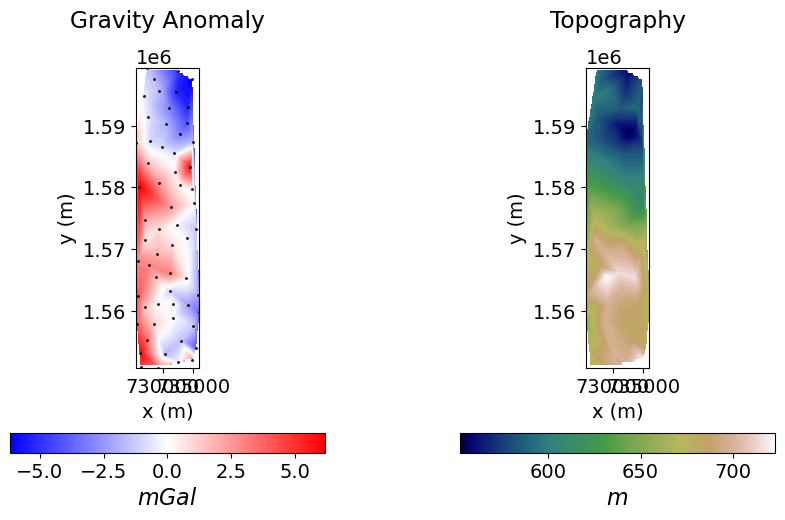

In [18]:
fig = plt.figure(figsize=(9, 5))

ax1 = fig.add_axes([0.05, 0.35, 0.35, 0.6])
plot2Ddata(
    receiver_locations,
    dobs,
    ax=ax1,
    dataloc=True,
    ncontour=40,
    contourOpts={"cmap": "bwr"},
)
ax1.set_title("Gravity Anomaly", pad=15)
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

cx1 = fig.add_axes([0.05, 0.18, 0.35, 0.04])
norm1 = mpl.colors.Normalize(vmin=-np.max(np.abs(dobs)), vmax=np.max(np.abs(dobs)))
cbar1 = mpl.colorbar.ColorbarBase(
    cx1, norm=norm1, orientation="horizontal", cmap=mpl.cm.bwr
)
cbar1.set_label("$mGal$", size=16)

ax2 = fig.add_axes([0.55, 0.35, 0.35, 0.6])
plot2Ddata(
    topo_xyz_clipped[:, 0:2],
    topo_xyz_clipped[:, -1],
    ax=ax2,
    ncontour=50,
    contourOpts={"cmap": "gist_earth"},
)
ax2.set_title("Topography", pad=15)
ax2.set_xlabel("x (m)")
ax2.set_ylabel("y (m)")

cx2 = fig.add_axes([0.55, 0.18, 0.35, 0.04])
norm2 = mpl.colors.Normalize(vmin=np.min(topo_xyz_clipped[:, -1]), vmax=np.max(topo_xyz_clipped[:, -1]))
cbar2 = mpl.colorbar.ColorbarBase(
    cx2, norm=norm2, orientation="horizontal", cmap=mpl.cm.gist_earth
)
cbar2.set_label("$m$", size=16)

plt.show()

##### (3) Defining uncertainity

In [20]:
maximum_anomaly = np.max(np.abs(dobs))
floor_uncertainty = 0.02 * maximum_anomaly
uncertainties = floor_uncertainty * np.ones(np.shape(dobs))
print("Floor uncertainty: {}".format(floor_uncertainty))

Floor uncertainty: 0.123048


In [21]:
# Define the receivers. The data consist of vertical gravity anomaly measurements.
# The set of receivers must be defined as a list.
receiver_list = gravity.receivers.Point(receiver_locations, components="gz")
receiver_list = [receiver_list]

# Define the source field
source_field = gravity.sources.SourceField(receiver_list=receiver_list)

# Define the survey
survey = gravity.survey.Survey(source_field)

In [22]:
data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)

##### (4) Setting up Grid

In [24]:
x_min, x_max = topo_xyz_clipped[:,0].min(), topo_xyz_clipped[:,0].max()
y_min, y_max = topo_xyz_clipped[:,1].min(), topo_xyz_clipped[:,1].max()
z_min, z_max = topo_xyz_clipped[:,2].min(), topo_xyz_clipped[:,2].max()

print(f"X Range: {x_min:.0f} to {x_max:.0f}")
print(f"Y Range: {y_min:.0f} to {y_max:.0f}")
print(f"Z Range (elevation): {z_min:.0f} to {z_max:.0f}")

X Range: 725639 to 735962
Y Range: 1550791 to 1599404
Z Range (elevation): 552 to 723


In [25]:
# Generate tensor mesh with top at z = 0 m
dh = 250                                                 # minimum cell size
dz = 200
npad = 1
hx = [(dh, npad, -1.3), (dh, 45), (dh, npad, 1.3)]  # discretization along x
hy = [(dh, npad, -1.3), (dh, 200), (dh, npad, 1.3)]   # discretization along y
hz = [(dz, 1, -1.3), (dz, 29)]                   # discretization along z

In [26]:
origin_x = topo_xyz_clipped[:,0].min() #- npad * dh
origin_y = topo_xyz_clipped[:,1].min() #- npad * dh
origin_z = -5000  

In [27]:
tensor_mesh = TensorMesh([hx, hy, hz], "CCN")

In [28]:
tensor_mesh.origin = np.r_[origin_x, origin_y, origin_z]

In [29]:
tensor_mesh

TensorMesh: 284,820 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     47    725,638.63    737,538.63    250.00    325.00    1.30
   y    202  1,550,790.54  1,601,440.54    250.00    325.00    1.30
   z     30     -5,000.00      1,060.00    200.00    260.00    1.30

In [30]:
active_tensor_cells = active_from_xyz(tensor_mesh, topo_xyz_clipped)
n_tensor_active = int(active_tensor_cells.sum())

In [34]:
print(f"Total Tensor Cells: {len(active_tensor_cells)} and Total Active Tensor Cells are: {n_tensor_active}")

Total Tensor Cells: 284820 and Total Active Tensor Cells are: 265591


In [39]:
tensor_model_map = maps.InjectActiveCells(tensor_mesh, active_tensor_cells, valInactive=0.0)
print(f"Mapping output dimensions: {tensor_model_map.shape[1]}")
print(f"Tensor Model Map Size is: {tensor_model_map.shape}")
assert tensor_model_map.shape[1] == np.sum(active_tensor_cells), "Mapping output mismatch"

Mapping output dimensions: 265591
Tensor Model Map Size is: (284820, 265591)


In [45]:
starting_tensor_model = np.zeros(tensor_mesh.nC)                           # Initialize full mesh size
starting_tensor_model[active_tensor_cells] = 1e-4                   # Only set active cells
starting_tensor_model = starting_tensor_model[active_tensor_cells]  # Get active portion
print(f"Starting model shape: {starting_tensor_model.shape}")

Starting model shape: (265591,)


In [46]:
reference_tensor_model = np.zeros_like(starting_tensor_model)

In [47]:
# Map for ignoring inactive cells when plotting
tensor_plotting_map = maps.InjectActiveCells(tensor_mesh, active_tensor_cells, np.nan)

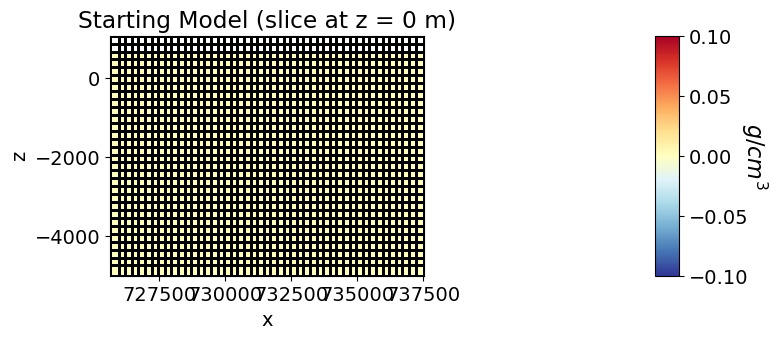

In [49]:
fig = plt.figure(figsize=(10, 3))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])
yind = 0
norm = mpl.colors.Normalize(vmin=-0.1, vmax=0.1)
tensor_mesh.plot_slice(
    tensor_plotting_map * starting_tensor_model,
    normal="Y",
    ax=ax1,
    ind=yind, #int(tensor_mesh.shape_cells[1] / 2),
    grid=True,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},

)
ax1.set_title("Starting Model (slice at z = 0 m)")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)
ax1.set_aspect(1.5)
ax2.set_aspect(50)
plt.savefig(rf"C:\Data\ONGC\AIKosh\OUTPUT\GM Data\SimPEG_Output\Wajrakur_Area\Initial Model at y = {yind}  with gridsize_{dh,dh,dz}m for Gravity Inversion.png",dpi=200)
plt.show()

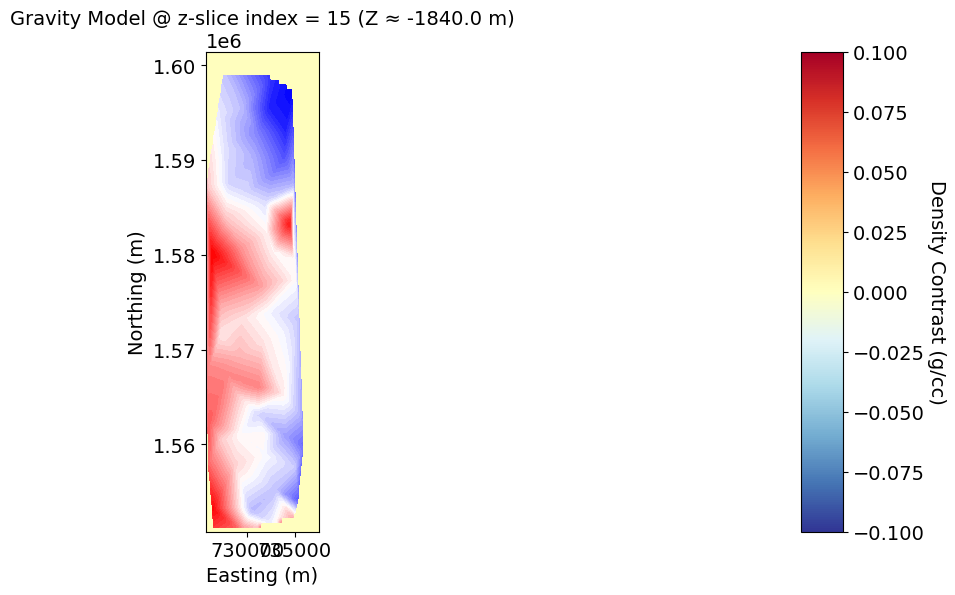

In [52]:
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

# Normalize color scale
norm = mpl.colors.Normalize(vmin=-0.1, vmax=0.1)

# Slice index in Z (e.g., middle slice)
z_index = int(tensor_mesh.shape_cells[2] / 2)
z_value = tensor_mesh.cell_centers_z[z_index]

# Plot the tensor mesh slice
im = tensor_mesh.plot_slice(
    tensor_plotting_map * starting_tensor_model,
    normal="Z",
    ax=ax1,
    ind=z_index,
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)
ax1.set_title(f"Gravity Model @ z-slice index = {z_index} (Z ≈ {z_value:.1f} m)", fontsize=14)
ax1.set_xlabel("Easting (m)")
ax1.set_ylabel("Northing (m)")
ax1.set_aspect("equal")

plot2Ddata(
    receiver_locations,
    dobs,
    ax=ax1,
    dataloc=False,
    ncontour=40,
    contourOpts={"cmap": "bwr"},
)
ax2.set_title("Gravity Anomaly", pad=15)
ax2.set_xlabel("x (m)")
ax2.set_ylabel("y (m)")

# Colorbar
ax3 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax3, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("Density Contrast (g/cc)", rotation=270, labelpad=15, size=14)
plt.show()

In [53]:
reg_L2 = regularization.WeightedLeastSquares(
    tensor_mesh,
    active_cells=active_tensor_cells,
    length_scale_x=1.0,
    length_scale_y=1.0,
    length_scale_z=1.0,
    reference_model=reference_tensor_model,
    reference_model_in_smooth=False,
)

In [54]:
simulation_L2 = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=tensor_mesh,
    rhoMap=tensor_model_map,
    store_sensitivities="disk",  # Better for large problems
    sensitivity_dtype=np.float32  # Reduce memory
)

# Test forward operation
try:
    pred = simulation_L2.dpred(starting_tensor_model)
    assert len(pred) == survey.nD
    print("Forward simulation successful!")
except Exception as e:
    print(f"Forward test failed: {str(e)}")

Found sensitivity file at .\sensitivity\sensitivity.npy with expected shape
Forward simulation successful!


In [65]:
# WORKS
# 1. Create data misfit
dmis_L2 = data_misfit.L2DataMisfit(
    simulation=simulation_L2,
    data=data_object
)

# 2. Create optimization
opt_L2 = optimization.ProjectedGNCG(
    maxIter=50,
    lower=0.0,  # Minimum density
    upper=2.0,   # Maximum density
    callback=lambda x: print(f"Current model norm: {np.linalg.norm(x)}")
)

# 3. Create inverse problem
inv_prob_L2 = inverse_problem.BaseInvProblem(
    dmis_L2,
    reg_L2,
    opt_L2
)

# 4. Simplified directives
directives_list_L2 = [
    directives.BetaEstimate_ByEig(),
    directives.BetaSchedule(coolingFactor=5, coolingRate=2),
    directives.TargetMisfit(chifact=1.0)
]

# 5. Run inversion
inv_L2 = inversion.BaseInversion(
    inv_prob_L2,
    directives_list_L2
)
recovered_model = inv_L2.run(starting_tensor_model)

The callback on the ProjectedGNCG Optimization was replaced.

Running inversion with SimPEG v0.24.0

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    


C:\Users\Kunal\anaconda3\Lib\site-packages\pymatsolver\wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.19e-05  2.60e+04  3.41e+04  2.60e+04    4.63e+02      0              
   1  1.19e-05  1.21e+04  1.46e+08  1.38e+04    3.38e+02      0              
   2  2.38e-06  4.17e+03  5.52e+08  5.48e+03    3.08e+02      0   Skip BFGS  
   3  2.38e-06  4.18e+03  5.00e+08  5.37e+03    3.09e+02      2   Skip BFGS  
   4  4.75e-07  6.50e+02  1.01e+09  1.13e+03    1.79e+02      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 2.6048e+03
0 : |xc-x_last| = 1.0088e+00 <= tolX*(1+|x0|) = 1.0515e-01
0 : |proj(x-g)-x|    = 1.7802e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 1.7802e+02 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      50    <= iter

In [77]:
# Test mapping application
test_output = tensor_model_map * starting_tensor_model
assert test_output.shape == (tensor_mesh.nC,), "Mapping application failed"
assert np.sum(test_output != 0) == np.sum(active_tensor_cells), "Active cells mismatch"

In [79]:
# Test regularization on starting model
try:
    reg_val = reg_L2(starting_tensor_model)
    print(f"Regularization value: {reg_val}")
except Exception as e:
    print(f"Regularization failed: {str(e)}")

Regularization value: 34083.888499999965


In [81]:
print("\n=== Final Dimension Verification ===")
print(f"Mesh cells: {tensor_mesh.nC}")
print(f"Active cells: {np.sum(active_tensor_cells)}")
print(f"Mapping shape: {tensor_model_map.shape}")
print(f"Model shape: {starting_tensor_model.shape}")
print(f"Survey locations: {survey.nD}")
print(f"Sensitivity shape: ({survey.nD}, {np.sum(active_tensor_cells)})")


=== Final Dimension Verification ===
Mesh cells: 284820
Active cells: 265591
Mapping shape: (284820, 265591)
Model shape: (265591,)
Survey locations: 61
Sensitivity shape: (61, 265591)


In [83]:
predicted_data = simulation_L2.dpred(recovered_model)

In [ ]:
np.save(output_dir + r'\SimPEG_Output\recovered_model_localized.npy', recovered_model)
np.save(output_dir + r'\SimPEG_Output\predicted_data_localized.npy', predicted_data)
np.save(output_dir + r'\SimPEG_Output\residuals_localized.npy', data_object.dobs - predicted_data)
np.save(output_dir + r'\SimPEG_Output\active_cells_localized.npy', active_tensor_cells)

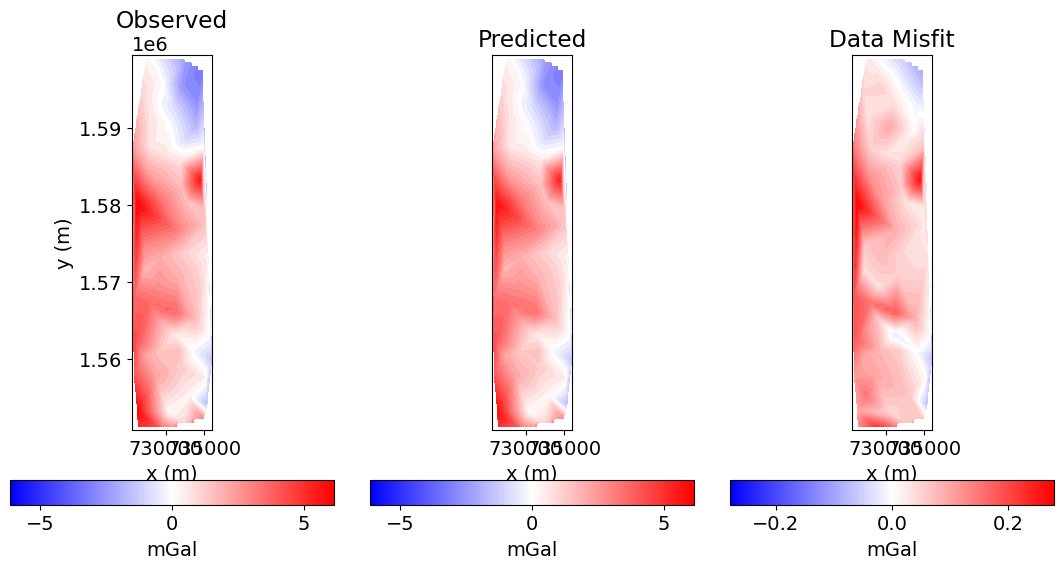

In [85]:
# Predicted data with final recovered model.
dpred = inv_prob_L2.dpred

# Observed data | Predicted data | Data misfit
data_array = np.c_[dobs, dpred, dobs - dpred]

fig = plt.figure(figsize=(12, 5))
plot_title = ["Observed", "Predicted", "Data Misfit"]
plot_units = ["mGal", "mGal", "mGal"]

ax1 = 3 * [None]
ax2 = 3 * [None]
norm = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]
v_lim = [np.max(np.abs(dobs)), np.max(np.abs(dobs)), np.max(np.abs(dobs - dpred))]

for ii in range(0, 3):
    ax1[ii] = fig.add_axes([0.3 * ii + 0.1, 0.2, 0.27, 0.75])
    norm[ii] = mpl.colors.Normalize(vmin=-v_lim[ii], vmax=v_lim[ii])
    cplot[ii] = plot2Ddata(
        receiver_list[0].locations,
        data_array[:, ii],
        ax=ax1[ii],
        ncontour=30,
        contourOpts={"cmap": "bwr", "norm": norm[ii]},
    )
    ax1[ii].set_title(plot_title[ii])
    ax1[ii].set_xlabel("x (m)")
    if ii == 0:
        ax1[ii].set_ylabel("y (m)")
    else:
        ax1[ii].set_yticks([])

    ax2[ii] = fig.add_axes([0.3 * ii + 0.1, 0.05, 0.27, 0.05])
    cbar[ii] = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm[ii], orientation="horizontal", cmap=mpl.cm.bwr
    )
    cbar[ii].ax.locator_params(nbins=3)
    cbar[ii].set_label(plot_units[ii], labelpad=5)

plt.show()

In [86]:
tensor_mesh.shape_cells

(47, 202, 30)

In [89]:
model3d = tensor_plotting_map * recovered_model
np.unique(model3d)

array([0.00000000e+00, 1.18032132e-08, 1.29154891e-08, ...,
       8.93982401e-01, 9.09889959e-01,            nan])

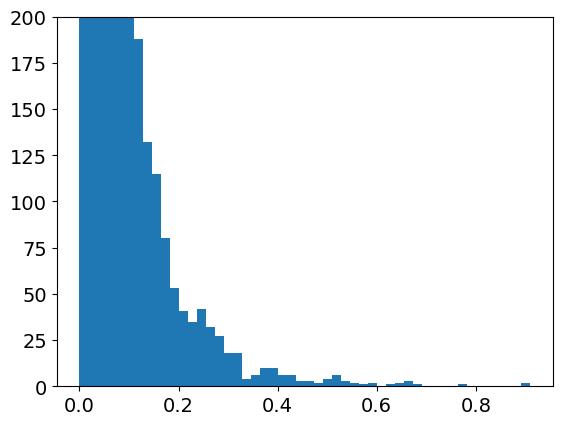

In [107]:
plt.hist(model3d,bins=50)
plt.ylim(0,200)
plt.show()

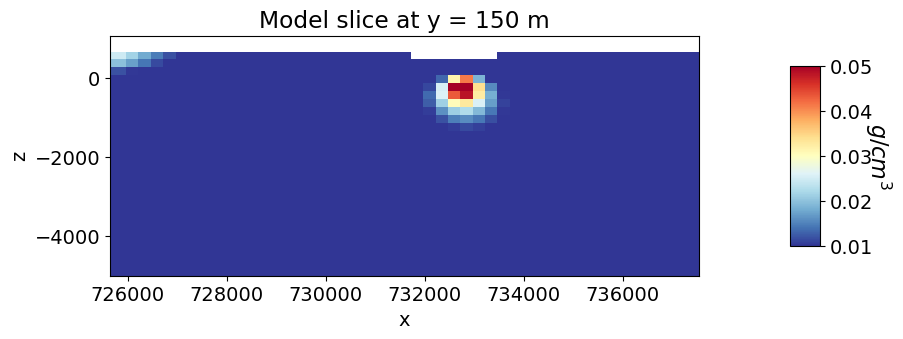

In [131]:
# Plot Recovered Model
density_min = 0.01
density_max = 0.05
fig = plt.figure(figsize=(10, 3))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

# Take middle Y index (for X-Z slice)
y_ind = 150 #int(mesh.shape_cells[1] / 2)

# Plot settings
norm = mpl.colors.Normalize(vmin=np.min(recovered_model),vmax=np.max(recovered_model))

tensor_mesh.plot_slice(tensor_plotting_map * recovered_model, normal="Y", 
                       ax=ax1, ind=y_ind, grid=False, 
                       pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm,"clim": [density_min, density_max]},)
ax1.set_title(f"Model slice at y = {y_ind} m")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)
ax1.set_aspect(0.80)
ax2.set_aspect(150)
plt.savefig(rf"C:\Data\ONGC\AIKosh\OUTPUT\GM Data\SimPEG_Output\South\Inverted_Density_Constrast_Model_Slice_at_{y_ind}_localized")
plt.show()

In [141]:
tensor_mesh.shape_cells[1]

202

In [147]:
density_min = 0.01
density_max = 0.05
for yind in range(0, tensor_mesh.shape_cells[1]):  # Loop from 0 to 116 inclusive
    fig = plt.figure(figsize=(10, 3))
    ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

    # Take middle Y index (for X-Z slice)
    #y_ind = 150 #int(mesh.shape_cells[1] / 2)

    # Plot settings
    norm = mpl.colors.Normalize(vmin=np.min(recovered_model),vmax=np.max(recovered_model))

    tensor_mesh.plot_slice(tensor_plotting_map * recovered_model, normal="Y", 
                       ax=ax1, ind=yind, grid=False, 
                       pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm,"clim": [density_min, density_max]},)
    ax1.set_title(f"Model slice at y = {yind} m")

    ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
    cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r)
    cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)
    ax1.set_aspect(0.80)
    ax2.set_aspect(150)
    output_path = rf"C:\Data\ONGC\AIKosh\OUTPUT\GM Data\SimPEG_Output\South\Inverted_Density_Constrast_Model_Slice_at_{yind}_localized.png"
    plt.savefig(output_path, dpi=300)
    plt.close(fig)  # Close the figure to release memory

In [149]:
import pyvista as pv

In [153]:
# 1. Inject recovered model to full mesh (NaN in inactive)
model_3d = tensor_plotting_map * recovered_model

In [ ]:
# 2. Apply mask: only retain values between 0.05 and 0.1
model_masked = np.where((model_3d >= 0.00) & (model_3d <= 0.01), model_3d, np.nan)

# 3. Get voxel centers
x, y, z = tensor_mesh.cell_centers[:, 0], tensor_mesh.cell_centers[:, 1], tensor_mesh.cell_centers[:, 2]
values = model_masked

In [ ]:
# 4. Filter only finite (non-NaN) voxels
mask = np.isfinite(values)
points = np.vstack([x[mask], y[mask], z[mask]]).T
values = values[mask]

In [ ]:
# 5. Create point cloud for smooth rendering
cloud = pv.PolyData(points)
cloud['density'] = values

In [ ]:
# 6. Start PyVista plot
plotter = pv.Plotter(window_size=(1000, 800))
plotter.add_mesh(cloud,
    scalars='density',
    cmap='inferno',
    render_points_as_spheres=True,
    point_size=6,
    nan_color='white'
)
plotter.add_axes()
plotter.view_vector([1, 0, 1])
plotter.add_title("Density Volume (0.00–0.10 g/cc)", font_size=14)
plotter.set_background("white")
plotter.show_axes()
plotter.show()

In [ ]:
%matplotlib inline

# Convert tensor mesh to PyVista-compatible grid
grid = pv.wrap(tensor_mesh.to_vtk())

# If needed, fill full model if only active cells were inverted
full_model = np.full(tensor_mesh.nC, np.nan)
full_model[active_tensor_cells] = recovered_model
grid.cell_data["Recovered_Model"] = full_model

# Plot it
plotter = pv.Plotter(notebook=False) 
plotter.add_mesh(grid, scalars="Recovered_Model", cmap="coolwarm", show_edges=False)
plotter.add_axes()
plotter.add_title("Recovered Model (3D TensorMesh)", font_size=14)
plotter.show()
